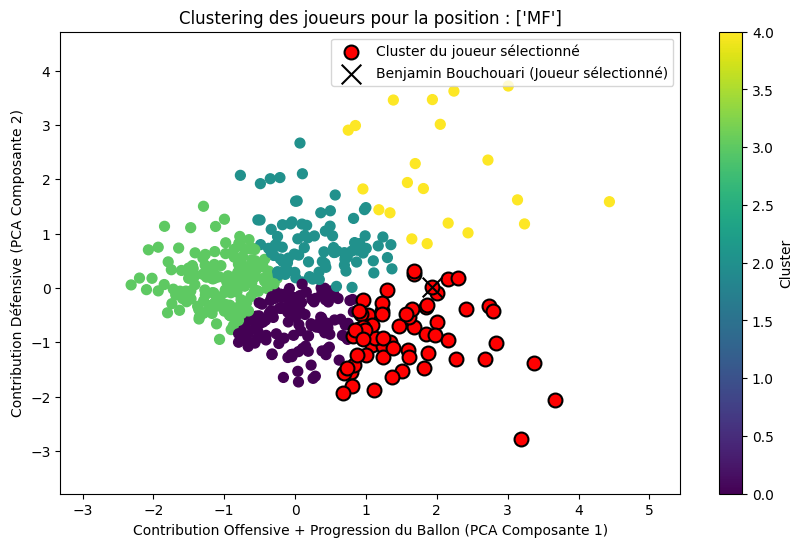

Joueurs de la même communauté que Benjamin Bouchouari (du plus proche au plus éloigné) :
Benjamin Bouchouari - Distance : 0.00
Pablo Torre - Distance : 0.13
Jude Bellingham - Distance : 0.27
Enzo Le Fée - Distance : 0.34
Ryan Gravenberch - Distance : 0.34
Frenkie de Jong - Distance : 0.37
Tijjani Reijnders - Distance : 0.40
Joe Aribo - Distance : 0.40
İlkay Gündoğan - Distance : 0.50
Adrian Bernabe - Distance : 0.62
Rodrigo De Paul - Distance : 0.63
Federico Valverde - Distance : 0.63
Declan Rice - Distance : 0.64
Aleksandr Golovin - Distance : 0.64
Alessandro Bianco - Distance : 0.77
Pedri - Distance : 0.78
Dani Ceballos - Distance : 0.83
Yacine Adli - Distance : 0.86
Pascal Groß - Distance : 0.86
Philipp Sander - Distance : 0.87
Kevin De Bruyne - Distance : 0.89
Iván Gil - Distance : 0.89
Álvaro Aguado - Distance : 0.97
Mikkel Damsgaard - Distance : 0.99
James Maddison - Distance : 1.00
João Neves - Distance : 1.03
Hong Hyunseok - Distance : 1.09
Jack Taylor - Distance : 1.11
Nikola 

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist  # Pour calculer les distances

# Charger les données
file_path = '../data/cleaned_scouting_report.csv'  # Remplacer par le bon chemin
data = pd.read_csv(file_path)

# Sélectionner un joueur par son nom
player_name = "Benjamin Bouchouari"  # Remplacer par le nom du joueur
selected_player = data[data['player_name'] == player_name]

# Obtenir la position du joueur
positions = selected_player['Position'].values[0].split(',')  # Diviser en cas de positions multiples

# Vérifier si le joueur a plusieurs positions ou une seule
if len(positions) > 1:
    # Si plusieurs positions, filtrer les joueurs ayant l'une ou l'autre des positions
    position_filter = '|'.join(positions)  # Créer une expression régulière pour capturer toutes les positions
    position_players = data[data['Position'].str.contains(position_filter, na=False)]
else:
    # Si une seule position, filtrer uniquement les joueurs ayant cette position
    position_players = data[data['Position'] == positions[0]]

# Définir les caractéristiques pour Contribution Offensive
offensive_features = [
    'Buts (sans les pénaltys)', 'npxG: xG sans les pénaltys', 'Passes décisives', 
    'xAG: Prévu(s) Buts assistés', 'npxG + xAG', 'Actions menant à un tir', 
    'Total des tirs', 'Passes progressives', 'Possessions progressives', 'Dribbles réussis'
]

# Définir les caractéristiques pour Contribution Défensive
defensive_features = [
    'Tacles', 'Interceptions', 'Balles contrées', 'Dégagements', 'Duel aérien gagnés'
]

# Combiner les deux ensembles de caractéristiques
all_features = offensive_features + defensive_features

# Filtrer le dataset pour ne garder que ces caractéristiques
features = position_players[all_features].dropna()

# Standardiser les caractéristiques
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Effectuer le clustering avec KMeans
kmeans = KMeans(n_clusters=5)  # Ajuster le nombre de clusters si nécessaire
position_players = position_players.loc[features.index]  # Assurer l'alignement
position_players['cluster'] = kmeans.fit_predict(scaled_features)

# Réduction de dimension avec PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

# Ajouter les composantes PCA au DataFrame pour référence
position_players['PCA_Component_1'] = pca_components[:, 0]
position_players['PCA_Component_2'] = pca_components[:, 1]

# Obtenir les coordonnées PCA du joueur sélectionné
selected_player_pca = pca_components[position_players['player_name'] == player_name]

# Calculer la distance entre le joueur sélectionné et tous les autres joueurs
distances = cdist(selected_player_pca, pca_components, metric='euclidean').flatten()

# Ajouter les distances dans le DataFrame
position_players['distance_to_selected'] = distances

# Trier les joueurs par distance au joueur sélectionné
sorted_players = position_players.sort_values(by='distance_to_selected')

# Tracer les clusters avec de nouveaux noms d'axes
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_components[:, 0], pca_components[:, 1], c=position_players['cluster'], cmap='viridis', s=50)
plt.title(f'Clustering des joueurs pour la position : {positions}')
plt.xlabel('Contribution Offensive + Progression du Ballon (PCA Composante 1)')
plt.ylabel('Contribution Défensive (PCA Composante 2)')
plt.colorbar(label='Cluster')

# Ajuster automatiquement les limites des axes en fonction des données
x_min, x_max = np.min(pca_components[:, 0]) - 1, np.max(pca_components[:, 0]) + 1
y_min, y_max = np.min(pca_components[:, 1]) - 1, np.max(pca_components[:, 1]) + 1
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# Mettre en évidence le cluster du joueur sélectionné
selected_cluster = position_players[position_players['player_name'] == player_name]['cluster'].values[0]
selected_cluster_points = pca_components[position_players['cluster'] == selected_cluster]

# Encadrer la communauté/cluster
plt.scatter(selected_cluster_points[:, 0], selected_cluster_points[:, 1], color='red', edgecolor='black', linewidth=1.5, s=100, label='Cluster du joueur sélectionné')

# Montrer où se trouve le joueur sélectionné dans son cluster
plt.scatter(selected_player_pca[0, 0], selected_player_pca[0, 1], color='black', marker='x', s=200, label=f'{player_name} (Joueur sélectionné)', zorder=5)

# Ajouter la légende et afficher le graphique
plt.legend()
plt.show()

# Filtrer les joueurs du même cluster (communauté) que le joueur sélectionné
players_in_same_cluster = sorted_players[sorted_players['cluster'] == selected_cluster]

# Imprimer les joueurs dans l'ordre des plus proches au plus éloigné au sein de la même communauté
print(f"Joueurs de la même communauté que {player_name} (du plus proche au plus éloigné) :")
for idx, row in players_in_same_cluster.iterrows():
    print(f"{row['player_name']} - Distance : {row['distance_to_selected']:.2f}")



### Explication des composantes PCA :
# Composante 1 (Contribution Offensive + Progression du Ballon) : Cet axe regroupe les actions offensives telles que :
# - Buts, expected goals, passes décisives, passes progressives, dribbles, et touches offensives.
# - Les joueurs avec des valeurs élevées sur cet axe sont plus impliqués dans l'attaque et la progression du ballon.

# Composante 2 (Contribution Défensive) : Cet axe regroupe les actions défensives comme :
# - Tacles, interceptions, dégagements, duels aériens gagnés, et balles contrées.
# - Les joueurs avec des valeurs élevées sur cet axe sont plus impliqués dans la défense.



/tmp/ipykernel_156876/1630428707.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  position_players['PCA_Component_1'] = pca_components[:, 0]
/tmp/ipykernel_156876/1630428707.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  position_players['PCA_Component_2'] = pca_components[:, 1]


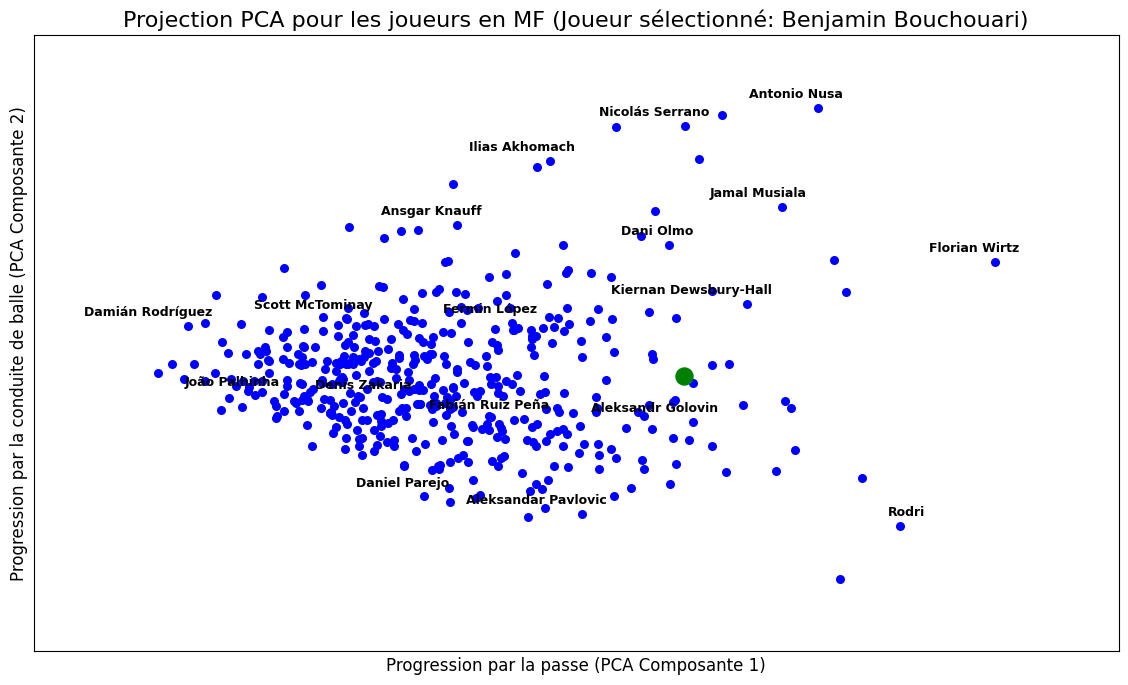


### Extrêmes pour Progression par la passe ###
Progression par la passe la plus élevée : Florian Wirtz, Valeur PCA : 4.435491459327147
Progression par la passe la plus faible : Kaishu Sano, Valeur PCA : -2.3141879048715452

### Extrêmes pour la Progression par la conduite de balle ###
Progression par la conduite de balle la plus élevée : Antonio Nusa, Valeur PCA : 3.7188931104632683
Progression par la conduite de balle la plus faible : Granit Xhaka, Valeur PCA : -2.7900067900150383


In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Charger les données
file_path = '../data/cleaned_scouting_report.csv'  # Remplacer par le bon chemin
data = pd.read_csv(file_path)

# Sélectionner un joueur par son nom
player_name = "Benjamin Bouchouari"  # Remplacer par le nom du joueur
selected_player = data[data['player_name'] == player_name]

# Obtenir la position du joueur
positions = selected_player['Position'].values[0].split(',')  # Diviser en cas de positions multiples

# Vérifier si le joueur a plusieurs positions ou une seule
if len(positions) > 1:
    # Si plusieurs positions, filtrer les joueurs ayant l'une ou l'autre des positions
    position_filter = '|'.join(positions)  # Créer une expression régulière pour capturer toutes les positions
    position_players = data[data['Position'].str.contains(position_filter, na=False)]
else:
    # Si une seule position, filtrer uniquement les joueurs ayant cette position
    position_players = data[data['Position'] == positions[0]]

# Définir les caractéristiques pour Contribution Offensive et Défensive
offensive_features = [
    'Passes progressives'
]
defensive_features = [
    'Possessions progressives'
]

# Combiner les deux ensembles de caractéristiques
all_features = offensive_features + defensive_features

# Filtrer le dataset pour ne garder que ces caractéristiques
features = position_players[all_features].dropna()

# Standardiser les caractéristiques
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Réduction de dimension avec PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

# Ajouter les composantes PCA au DataFrame pour référence
position_players['PCA_Component_1'] = pca_components[:, 0]
position_players['PCA_Component_2'] = pca_components[:, 1]

# Obtenir les coordonnées PCA du joueur sélectionné
selected_player_pca = pca_components[position_players['player_name'] == player_name]

# Calculer la distance entre tous les points
threshold_distance = 1  # Seuil pour l'affichage des noms
displayed_names = []

# Tracer les joueurs avec des points plus petits et sans les clusters ni légendes, avec une taille de figure plus grande
plt.figure(figsize=(14, 8))
scatter = plt.scatter(pca_components[:, 0], pca_components[:, 1], color='blue', s=30)  # Taille des points réduite

# Mettre en évidence le joueur sélectionné avec un gros point vert
plt.scatter(selected_player_pca[0, 0], selected_player_pca[0, 1], color='green', s=150, zorder=5)  # Taille réduite

# Afficher le nom de chaque joueur uniquement si les points sont suffisamment éloignés les uns des autres
for i, row in position_players.iterrows():
    name = row['player_name']
    x, y = row['PCA_Component_1'], row['PCA_Component_2']
    
    # Vérifier la distance entre ce point et tous les points déjà affichés
    too_close = False
    for x_disp, y_disp in displayed_names:
        if np.linalg.norm([x - x_disp, y - y_disp]) < threshold_distance:
            too_close = True
            break
    
    # Si aucun point trop proche, afficher le nom en gras
    if not too_close or player_name == name:
        plt.text(x+0.2, y+0.1, name, fontsize=9, ha='right', va='bottom', fontweight='bold')  # Texte en gras
        displayed_names.append((x, y))

# Ajouter un titre personnalisé
plt.title(f'Projection PCA pour les joueurs en {positions[0]} (Joueur sélectionné: {player_name})', fontsize=16)

# Ajouter des légendes pour les axes
plt.xlabel('Progression par la passe (PCA Composante 1)', fontsize=12)
plt.ylabel('Progression par la conduite de balle (PCA Composante 2)', fontsize=12)

# Ajuster automatiquement les limites des axes en fonction des données
x_min, x_max = np.min(pca_components[:, 0]) - 1, np.max(pca_components[:, 0]) + 1
y_min, y_max = np.min(pca_components[:, 1]) - 1, np.max(pca_components[:, 1]) + 1
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# Enlever les légendes des ticks des axes
plt.xticks([])
plt.yticks([])
plt.show()

# Afficher les extrêmes de la Contribution Offensive et Défensive

# Extrêmes pour Progression par la passe (PCA Composante 1)
max_offensive = position_players.loc[position_players['PCA_Component_1'].idxmax()]
min_offensive = position_players.loc[position_players['PCA_Component_1'].idxmin()]

print("\n### Extrêmes pour Progression par la passe ###")
print(f"Progression par la passe la plus élevée : {max_offensive['player_name']}, Valeur PCA : {max_offensive['PCA_Component_1']}")
print(f"Progression par la passe la plus faible : {min_offensive['player_name']}, Valeur PCA : {min_offensive['PCA_Component_1']}")

# Extrêmes pour la Progression par la conduite de balle (PCA Composante 2)
max_defensive = position_players.loc[position_players['PCA_Component_2'].idxmax()]
min_defensive = position_players.loc[position_players['PCA_Component_2'].idxmin()]

print("\n### Extrêmes pour la Progression par la conduite de balle ###")
print(f"Progression par la conduite de balle la plus élevée : {max_defensive['player_name']}, Valeur PCA : {max_defensive['PCA_Component_2']}")
print(f"Progression par la conduite de balle la plus faible : {min_defensive['player_name']}, Valeur PCA : {min_defensive['PCA_Component_2']}")
